In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Eye Paper/data"
classes = ['Cataract', 'Conjunctivitis', 'Eyelid', 'Normal', 'Uveitis']

Mounted at /content/drive


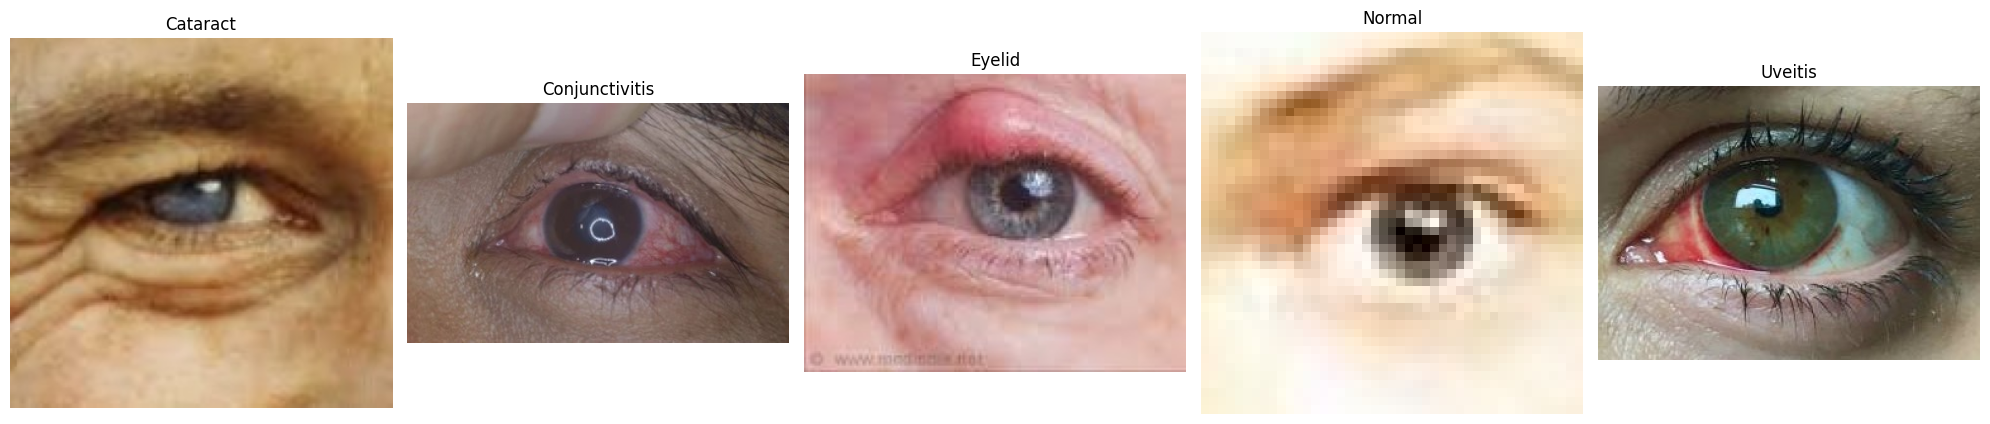

In [3]:
import os
import cv2
import matplotlib.pyplot as plt

def visualize_dataset_example(base_path, classes):
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 5))
    for i, cls in enumerate(classes):
        folder = os.path.join(base_path, cls)
        img_name = os.listdir(folder)[0]
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(cls)
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()

visualize_dataset_example(dataset_path, classes)

In [5]:
pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 5.1 MB/s eta 0:00:00


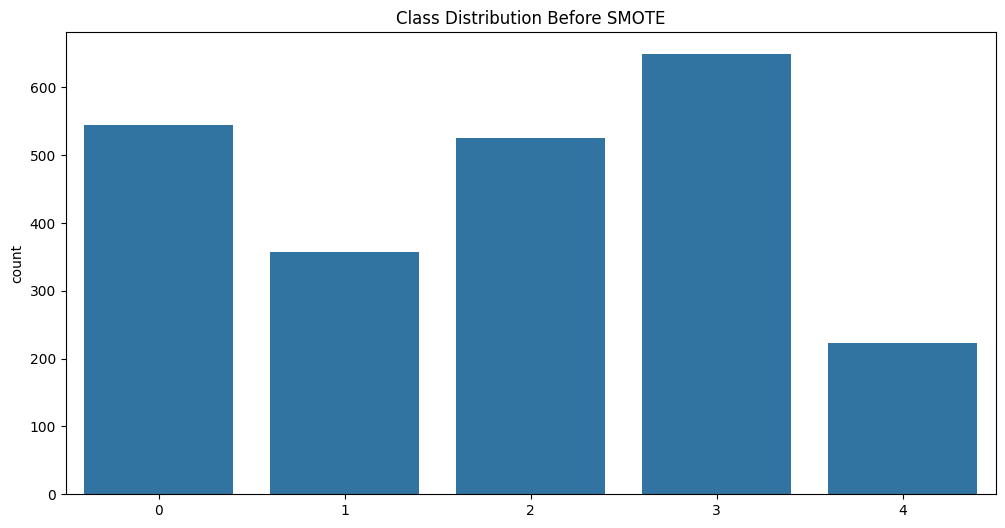

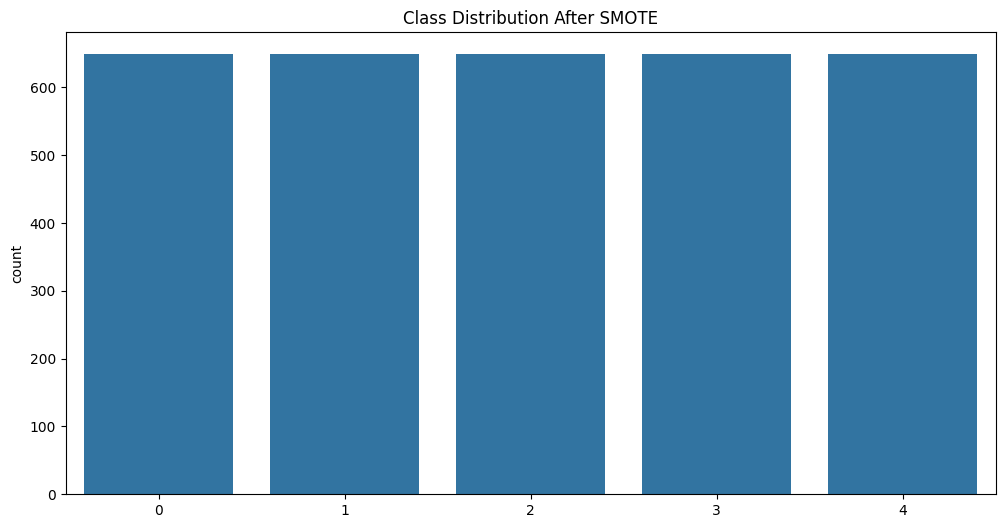

In [6]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import seaborn as sns

data = []
labels = []

for cls_id, cls_name in enumerate(classes):
    folder = os.path.join(dataset_path, cls_name)
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224, 224))
        data.append(img)
        labels.append(cls_id)

data = np.array(data)
labels = np.array(labels)

data_flat = data.reshape(len(data), -1)

smote = SMOTE(random_state=42)
data_balanced, labels_balanced = smote.fit_resample(data_flat, labels)

data_balanced = data_balanced.reshape(-1, 224, 224, 3)

def visualize_class_distribution(labels_before, labels_after):
    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_before)
    plt.title("Class Distribution Before SMOTE")
    plt.show()

    plt.figure(figsize=(12, 6))
    sns.countplot(x=labels_after)
    plt.title("Class Distribution After SMOTE")
    plt.show()

visualize_class_distribution(labels, labels_balanced)

In [7]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data_balanced, labels_balanced, test_size=0.2, random_state=42)

In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

class EyeDiseaseDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img = self.data[idx]
        label = self.labels[idx]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if self.transform:
            img = self.transform(img)
        else:
            img = torch.tensor(img).permute(2, 0, 1) / 255.0
        return img.float(), label

train_dataset = EyeDiseaseDataset(train_data, train_labels, transform=transform)
test_dataset = EyeDiseaseDataset(test_data, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
from torchvision import models
import torch.nn as nn
from torch.optim import Adam

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_vgg16 = models.vgg16(pretrained=True)
model_vgg16.classifier[6] = nn.Linear(model_vgg16.classifier[6].in_features, len(classes))
model_vgg16 = model_vgg16.to(device)

def train_model(model, train_loader, test_loader, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=0.0001)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        correct, total, running_loss = 0, 0, 0
        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / total)

        model.eval()
        correct, total, running_loss = 0, 0, 0
        with torch.no_grad():
            for imgs, labels in test_loader:
                imgs, labels = imgs.to(device), labels.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, labels)
                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss.append(running_loss / len(test_loader))
        val_acc.append(correct / total)

        print(f"Epoch {epoch+1}/{num_epochs}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")

    return train_loss, val_loss, train_acc, val_acc

train_loss, val_loss, train_acc, val_acc = train_model(model_vgg16, train_loader, test_loader, num_epochs=10)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 227MB/s]


Epoch 1/10: Train Acc=0.7300, Val Acc=0.8906
Epoch 2/10: Train Acc=0.9006, Val Acc=0.9430
Epoch 3/10: Train Acc=0.9353, Val Acc=0.8814
Epoch 4/10: Train Acc=0.9653, Val Acc=0.9029
Epoch 5/10: Train Acc=0.9642, Val Acc=0.9476
Epoch 6/10: Train Acc=0.9788, Val Acc=0.9707
Epoch 7/10: Train Acc=0.9719, Val Acc=0.9384
Epoch 8/10: Train Acc=0.9784, Val Acc=0.9492
Epoch 9/10: Train Acc=0.9935, Val Acc=0.9368
Epoch 10/10: Train Acc=0.9723, Val Acc=0.9014



Confusion Matrix:


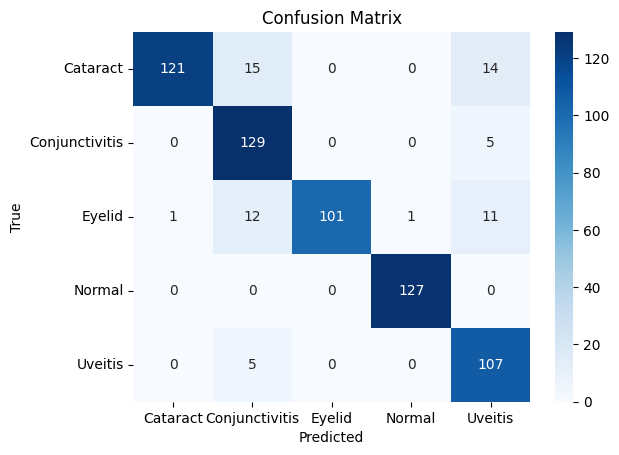


Classification Report:
                precision    recall  f1-score   support

      Cataract       0.99      0.81      0.89       150
Conjunctivitis       0.80      0.96      0.87       134
        Eyelid       1.00      0.80      0.89       126
        Normal       0.99      1.00      1.00       127
       Uveitis       0.78      0.96      0.86       112

      accuracy                           0.90       649
     macro avg       0.91      0.91      0.90       649
  weighted avg       0.92      0.90      0.90       649


Metrics for Each Class:
Class: Cataract
  TP: 121, FP: 1, TN: 498, FN: 29
Class: Conjunctivitis
  TP: 129, FP: 32, TN: 483, FN: 5
Class: Eyelid
  TP: 101, FP: 0, TN: 523, FN: 25
Class: Normal
  TP: 127, FP: 1, TN: 521, FN: 0
Class: Uveitis
  TP: 107, FP: 30, TN: 507, FN: 5


In [10]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("\nConfusion Matrix:")
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))

    # Calculate TP, FP, TN, FN
    tp = np.diag(cm)
    fp = np.sum(cm, axis=0) - tp
    fn = np.sum(cm, axis=1) - tp
    tn = np.sum(cm) - (fp + fn + tp)

    print("\nMetrics for Each Class:")
    for i, cls in enumerate(classes):
        print(f"Class: {cls}")
        print(f"  TP: {tp[i]}, FP: {fp[i]}, TN: {tn[i]}, FN: {fn[i]}")

    return cm, y_true, y_pred

# Evaluate the Model
cm, y_true, y_pred = evaluate_model(model_vgg16, test_loader)

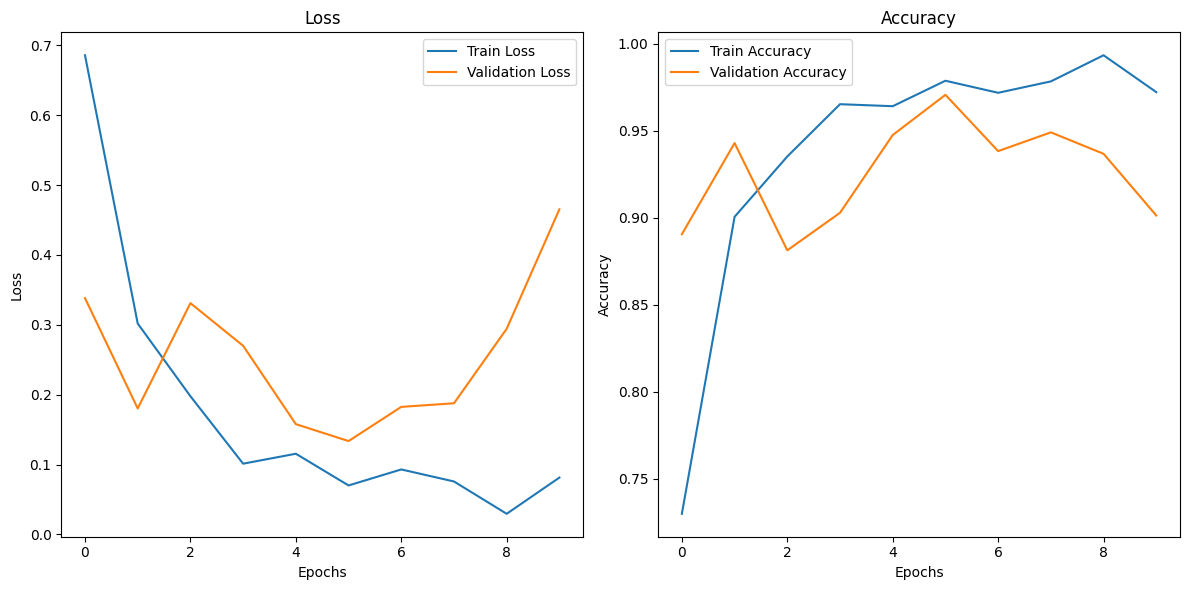

In [11]:
def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 6))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot Training Curves
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

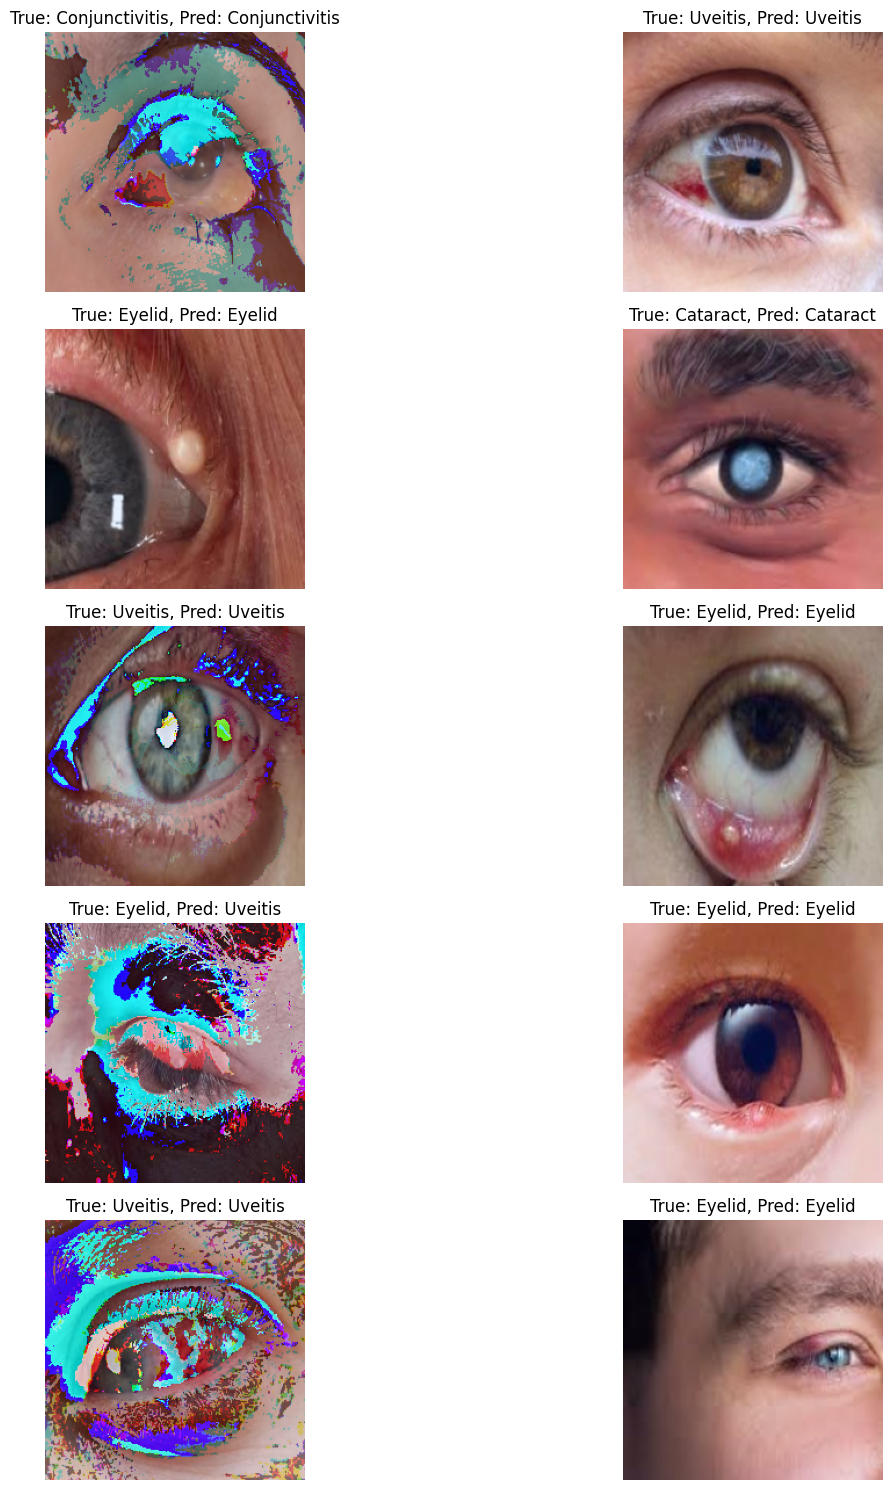

In [12]:
def show_results(model, test_loader, num_images=10):
    model.eval()
    count = 0
    plt.figure(figsize=(15, 15))
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1)

            for i in range(len(imgs)):
                if count == num_images:
                    break
                img = imgs[i].permute(1, 2, 0).cpu().numpy()
                img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
                plt.subplot(5, 2, count + 1)
                plt.imshow(img)
                plt.title(f"True: {classes[labels[i]]}, Pred: {classes[preds[i]]}")
                plt.axis("off")
                count += 1
            if count == num_images:
                break
    plt.tight_layout()
    plt.show()

# Show Results
show_results(model_vgg16, test_loader)

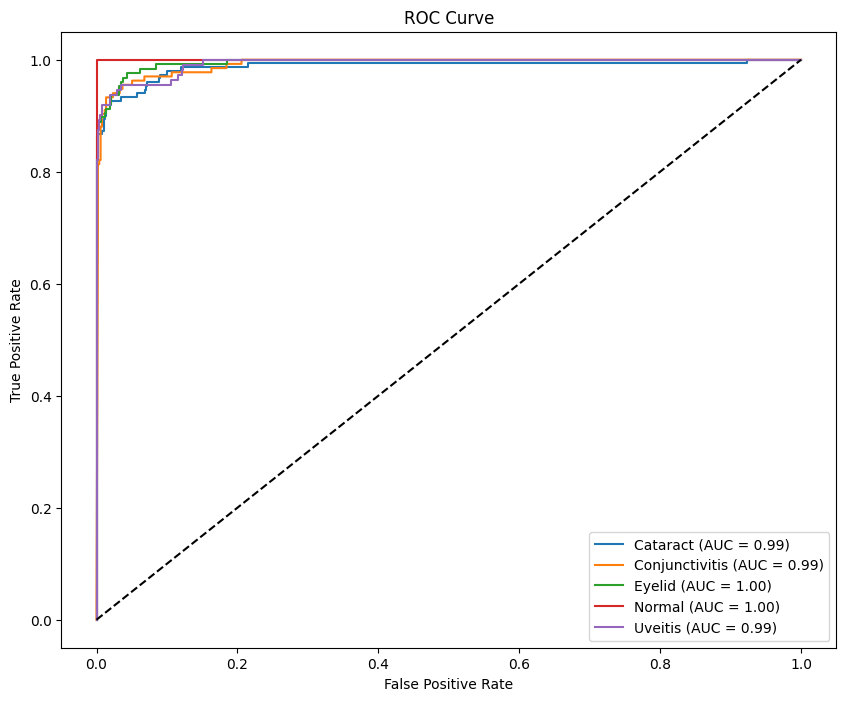

In [13]:
def plot_roc_curve(model, test_loader):
    y_true_binary = np.zeros((len(y_true), len(classes)))
    for idx, val in enumerate(y_true):
        y_true_binary[idx, val] = 1

    model.eval()
    y_pred_probs = []
    with torch.no_grad():
        for imgs, _ in test_loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            y_pred_probs.extend(probs)

    y_pred_probs = np.array(y_pred_probs)

    plt.figure(figsize=(10, 8))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cls} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC Curve
plot_roc_curve(model_vgg16, test_loader)

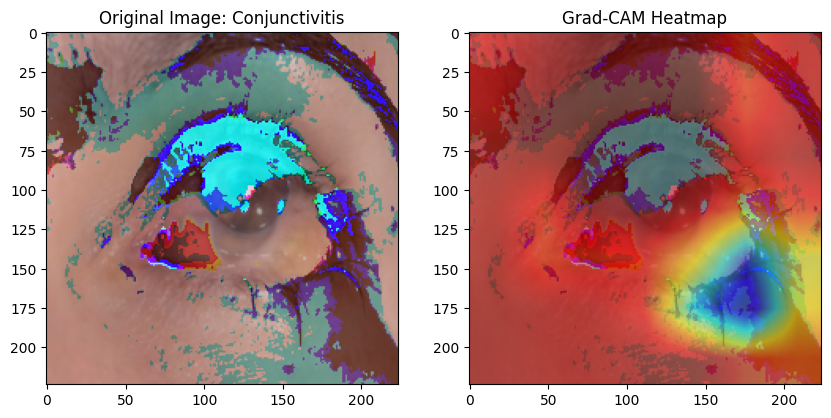

In [14]:
class GradCam:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, class_idx):
        weights = torch.mean(self.gradients, dim=(2, 3))
        heatmap = torch.zeros(self.activations.shape[2:], dtype=torch.float32)
        for i, w in enumerate(weights[0]):
            heatmap += w * self.activations[0, i, :, :]
        heatmap = np.maximum(heatmap.cpu().detach().numpy(), 0)
        heatmap = cv2.resize(heatmap, (224, 224))
        heatmap = heatmap / np.max(heatmap)
        return heatmap

    def __call__(self, input_img, target_class):
        input_img.requires_grad = True
        output = self.model(input_img)
        self.model.zero_grad()
        class_score = output[0, target_class]
        class_score.backward()
        return self.generate_heatmap(class_idx=target_class)

# Visualize Grad-CAM
def visualize_gradcam(model, grad_cam, img, label, class_names):
    img_tensor = img.unsqueeze(0).to(device)
    heatmap = grad_cam(img_tensor, label)

    img = img.permute(1, 2, 0).cpu().numpy()
    img = (img - img.min()) / (img.max() - img.min())

    heatmap = cv2.applyColorMap(np.uint8(255 * heatmap), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    overlay = heatmap + np.float32(img)
    overlay = overlay / overlay.max()

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image: {class_names[label]}")
    plt.imshow(img)
    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(overlay)
    plt.show()

grad_cam = GradCam(model_vgg16, target_layer=model_vgg16.features[-1])

for img, label in test_loader:
    visualize_gradcam(model_vgg16, grad_cam, img[0], label[0], classes)
    break